In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from datetime import datetime
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import SGDRegressor
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge, RidgeCV, Lasso

### deleting HTML

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

### read JSON with escape

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

### Parsing JSON

In [4]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)
            for i, feat in enumerate(features):
                if feat == 'published':
                    info = json_data[feat]['$date']
                elif feat == 'author':
                    info = json_data[feat]['twitter']
                    if info:
                        info = info.replace('\n', ' ').replace('@', ' ')
                    else:
                        info = ''
                elif feat == 'content' or feat == 'title':
                    info = json_data[feat].replace('\n', ' ').replace('\r', ' ')
                    info = strip_tags(info)                   
                feature_files[i].write(info + '\n')

In [7]:
extract_features_and_write('', 'train.json', is_train=True)

In [8]:
%%time
extract_features_and_write('', 'test.json', is_train=False)


Wall time: 1min 47s


In [59]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=120000)

In [60]:
%%time
with open('train_content.txt', encoding='utf-8') as input_train_file:
    X_train_content_sparse = tfidf_vectorizer.fit_transform(input_train_file)
    
with open('test_content.txt', encoding='utf-8') as input_test_file:
    X_test_content_sparse = tfidf_vectorizer.transform(input_test_file)

Wall time: 6min 25s


In [62]:
X_train_content_sparse.shape, X_test_content_sparse.shape

((62313, 120000), (34645, 120000))

In [63]:
%%time
tfidf_vectorizer_title = TfidfVectorizer(ngram_range=(1, 3),
                                         max_features=120000)

with open('train_title.txt', encoding='utf-8') as input_train_file:
    X_train_title_sparse = tfidf_vectorizer_title.fit_transform(input_train_file)
    
with open('test_title.txt', encoding='utf-8') as input_test_file:
    X_test_title_sparse = tfidf_vectorizer_title.transform(input_test_file)

Wall time: 4.73 s


In [64]:
X_train_title_sparse.shape, X_test_title_sparse.shape

((62313, 120000), (34645, 120000))

In [65]:
def add_time_features(path_to_publication_time_file):

    df = pd.read_csv(path_to_publication_time_file, names=['time'])
    df['time'] = df['time'].apply(lambda t: 
                              pd.to_datetime(t.replace('T', ' ').replace('Z', '')))
    df['hour'] = df['time'].apply(lambda ts: ts.hour)
    df['month'] = df['time'].apply(lambda ts: ts.month)
    
    df['weekend'] = df['time'].apply(lambda ts: ts.weekday() == 5 or
                                 ts.weekday() == 6).astype('int')
    
    df['day'] = ((df['hour'] >= 12) & (df['hour'] <= 18)).astype('int')
    df['morning'] = ((df['hour'] >= 7) & (df['hour'] <= 11)).astype('int')
    df['night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype('int')
    
    cols = ['day', 'morning', 'night', 'month', 'weekend']
    X_time_features_sparse = csr_matrix(df[cols].values)
    
    return X_time_features_sparse

In [66]:
%%time
X_train_time_features_sparse = add_time_features('train_published.txt')
X_test_time_features_sparse = add_time_features('test_published.txt')

Wall time: 10.7 s


In [67]:
X_train_time_features_sparse.shape, X_test_time_features_sparse.shape

((62313, 5), (34645, 5))

### Adding authors

In [68]:
%%time
author_train = pd.read_csv('train_author.txt', names=['author'],
                          skip_blank_lines=False)
author_train = pd.get_dummies(author_train)

author_test = pd.read_csv('test_author.txt', names=['author'],
                          skip_blank_lines=False)
author_test = pd.get_dummies(author_test)

unique_authors_train = list(set(author_train.columns) - set(author_test.columns))
unique_authors_test = list(set(author_test.columns) - set(author_train.columns))

author_test = author_test.drop(unique_authors_test, axis=1)
author_train = author_train.drop(unique_authors_train, axis=1)

X_train_author_sparse = csr_matrix(author_train.values)
X_test_author_sparse = csr_matrix(author_test.values)

Wall time: 28 s


In [69]:
X_train_author_sparse.shape, X_test_author_sparse.shape

((62313, 4587), (34645, 4587))

**Join all sparse matrices.**

In [70]:
%%time
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,
                                    X_train_author_sparse, X_train_time_features_sparse]))

Wall time: 6.41 s


In [71]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,
                                    X_test_author_sparse, X_test_time_features_sparse]))

In [72]:
X_train_sparse.shape, X_test_sparse.shape

((62313, 244592), (34645, 244592))

## Read train target and split data

In [73]:
train_target = pd.read_csv('train_log1p_recommends.csv', 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [74]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]
X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

## Train a simple Ridge model and check MAE on the validation set

In [75]:
%%time
ridge_reg = Ridge(random_state=17)
ridge_reg.fit(X_train_part_sparse, y_train_part)
ridge_valid_pred = ridge_reg.predict(X_valid_sparse)
print(mean_absolute_error(y_valid, ridge_valid_pred))

1.0959193675906271
Wall time: 1min 19s


### Plot distributions of tagets and predictions

In [76]:
from matplotlib import pyplot as plt
%matplotlib inline

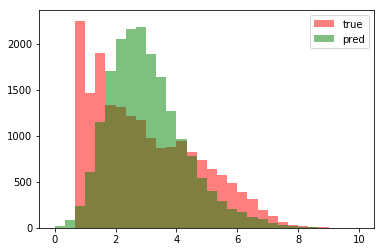

In [77]:
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_valid_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.legend();

In [78]:
%%time
ridge_reg.fit(X_train_sparse, y_train)
ridge_test_pred = ridge_reg.predict(X_test_sparse)

Wall time: 2min 10s


In [81]:
def write_submission_file(prediction, filename,
                          path_to_sample='sample_submission.csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [82]:
write_submission_file(ridge_test_pred, 'medium_1.csv')

In [83]:
write_submission_file(np.zeros_like(ridge_test_pred), 
                      'medium_all_zeros_submission.csv')

In [84]:
mean_test_target = 4.33328

In [85]:
y_train.mean()

3.051538598205832

In [86]:
ridge_test_pred_modif = ridge_test_pred + mean_test_target - y_train.mean()

In [87]:
write_submission_file(ridge_test_pred_modif, 
                      'medium_submission_kikin.csv')